<a href="https://colab.research.google.com/github/rodrigogoulart/IAC/blob/main/face-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento: Reconhecimento de faces

Este experimento envolve o conceito de Visão Computacional. Para desenvolver o estudo vamos utilizar o dataset __[*Labeled Faces in the Wild* (LFW)](https://vis-www.cs.umass.edu/lfw/)__ e o código é baseado em um exemplo disponibilizado pelo __[scikit-learn](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)__.

O dataset LFW é um conjunto de fotografias projetado para o estudo do problema do reconhecimento de rostos. Para isso foram coletadas imagens de rostos na internet e cada foto foi posteriormente etiquetada (labeled) de forma a indicar a pessoa presente na imagem.

O dataset contém mais de **13.000 imagens**, sendo **1680 das pessoas retratadas têm duas ou mais fotos distintas** no conjunto de dados.

![](https://github.com/rodrigogoulart/IAC/blob/main/LFW-1.png?raw=true "Fonte: LFW")<br>
<small>(Fonte: capturado de __[LFW](https://vis-www.cs.umass.edu/lfw/)__ em 1/5/24)</small>

Há quatro conjuntos diferentes de imagens do LFW: o original e três tipos diferentes de imagens "alinhadas". Imagens alinhadas são todas aquelas do conjunto original que foram ajustadas (rotação) para que o rosto fique "em pé".

![](https://github.com/rodrigogoulart/IAC/blob/main/LFW-2.png?raw=true "Fonte LFW") <br>
<small>(Fonte: capturado de __[LFW](https://vis-www.cs.umass.edu/lfw/)__ em 1/5/24)</small>

Dentre todos os conjuntos, LFW-a e as imagens profundamente funiladas produzem resultados superiores para a maioria dos algoritmos de verificação de rosto em comparação com as imagens originais e as imagens funiladas (ICCV 2007 apud __[LFW](https://vis-www.cs.umass.edu/lfw/)__).

## Acesso e análise dos dados

Sendo assim temos um código que carrega imagens de pessoas com pelo menos 70 imagens (considerando todos os conjuntos) e as redimensiona com uma taxa de 0,4.

In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
for name in lfw_people.target_names:
    print(name)

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


<br>
Então fazemos um levantamento das caracteristicas do dadaset estabelecido:<br>

**n_samples**: número de imagens<br>
**h**: altura das imagens redimensionadas<br>
**w**: largura das imagens redimensionadas

In [2]:
n_samples, h, w = lfw_people.images.shape
n_samples,h,w

(1288, 50, 37)

<br>Como exemplos (X) são utilizados os dados de cada imagem.
O array ***lfw_people.data*** retorna array numpy em que cada linha corresponde a um conjunto de features que representam numéricamente os pontos de cada imagem (resolução original 62 x 47). Neste caso, como as imagens foram redimensionadas, o número para a resolução de 50 x 37, ou seja, 1850 features.

In [3]:
X = lfw_people.data
n_features = X.shape[1]
X,n_features

(array([[0.9973857 , 0.99607843, 0.9921568 , ..., 0.38169935, 0.38823533,
         0.3803922 ],
        [0.14771242, 0.19738562, 0.1751634 , ..., 0.45751634, 0.44444445,
         0.53594774],
        [0.34379086, 0.39477125, 0.49150327, ..., 0.709804  , 0.72156864,
         0.7163399 ],
        ...,
        [0.3633987 , 0.3372549 , 0.30718955, ..., 0.19738562, 0.22091503,
         0.19346406],
        [0.19346406, 0.24705882, 0.34248367, ..., 0.7346406 , 0.6640523 ,
         0.6117647 ],
        [0.11633987, 0.10196079, 0.1267974 , ..., 0.13333334, 0.13725491,
         0.2535948 ]], dtype=float32),
 1850)

<br>A etiqueta (label) que será prevista (predicted) é o ID da pessoa. As classes já são disponibilizadas pelo scikit-learn com o array *lfw_people.target*

In [4]:
y = lfw_people.target
len(y) #número de exemplos de classe do dataset, que é o mesmo de n_samples

1288

In [5]:
target_names = lfw_people.target_names
target_names # nomes das pessoas

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [6]:
n_classes = target_names.shape[0]
n_classes # número de classes (pessoas) para o aprendizado

7

In [7]:
print("Tamanho total do dataset:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Tamanho total do dataset:
n_samples: 1288
n_features: 1850
n_classes: 7


## Pré-processamento

### Separação em Treino e Teste
Com base nos exemplos (X) e classes (y) __[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)__ separa os dados de maneira aleatória e separar os dados em treino (75%) e teste (25%). Então __[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)__ padroniza os atributos subtraindo a média dos valores e dividindo cada um pelo desvio padrão.

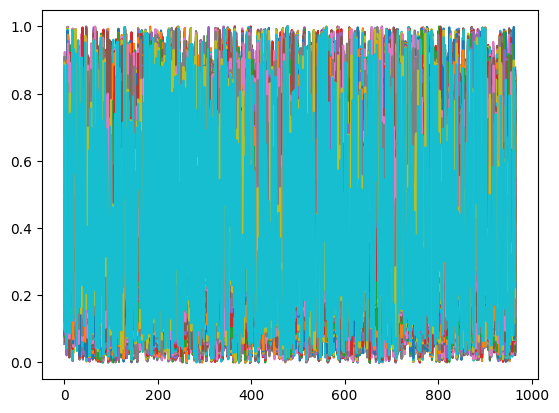

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42 # valor inteiro que fixa (seed) os resultados em diferentes chamadas.
)

plt.plot(X_train)
plt.show()

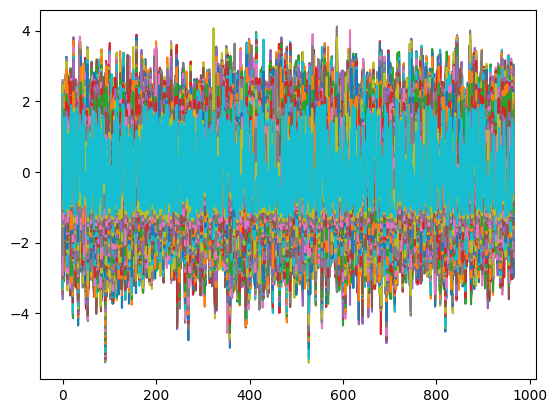

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(X_train)
plt.show()

In [10]:
len(X_train), len(X_test)

(966, 322)

### PCA - Eigenfaces
Com base nos exemplos de treinamento o método não supervisionado de Análise de Componentes Principais (sigla em inglês PCA) com __[pca.components_.reshape](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)__ são extraídos 150 atributos (dos até então 1850), que representam a extração de um padrão para identificar o espaço em que o rosto se encontra. Este é um processo de redução de dimensionalidade, e gera um novo dataset com apenas 150 atributos, transformando os dados dos exemplos do conjunto X_train e X_test em X_train_pca e X_teste_pca, respectivamente.

In [11]:
from time import time
from sklearn.decomposition import PCA

n_components = 150

print("extraindo as top %d eigenfaces de %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X_train)
print("feito em %0.3fs" % (time() - t0))

## gera um conjunto com os padrões extraídos nas dimensões utilizadas até aqui
eigenfaces = pca.components_.reshape((n_components, h, w))

extraindo as top 150 eigenfaces de 966 faces
feito em 0.443s


In [12]:
# função para pltar a galeria de retratos
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "previsto: %s\ncorreto:      %s" % (pred_name, true_name)

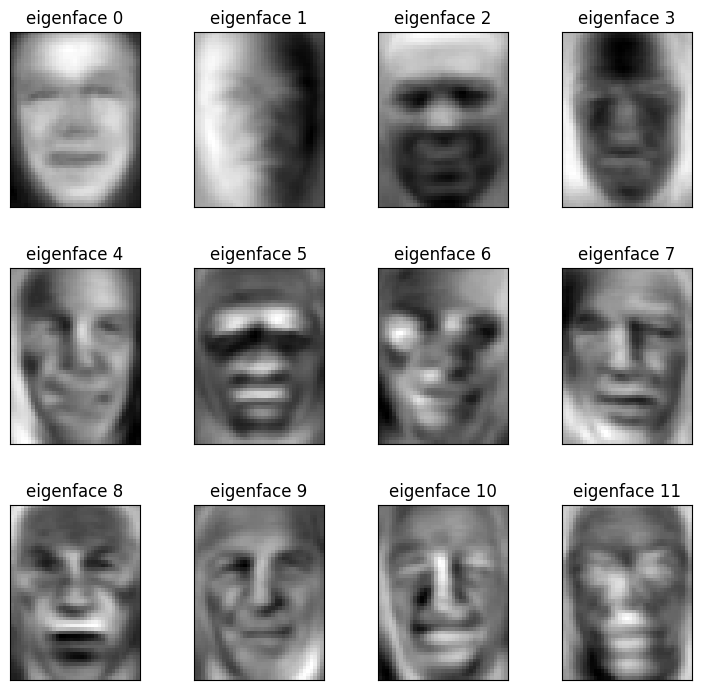

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [14]:
print("gerando novo dataset com apenas 150 atributos, transformando os dados dos exemplos do conjunto X_train e X_test ")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("feito em %0.3fs" % (time() - t0))

gerando novo dataset com apenas 150 atributos, transformando os dados dos exemplos do conjunto X_train e X_test 
feito em 0.032s


In [15]:
len(X_train_pca),len(X_test_pca)

(966, 322)

## Processamento

### Treinamento
Neste exemplo é produzido um modelo de classificador __[SVM (Support Vector Machines)](https://scikit-learn.org/stable/modules/svm.html)__. Ele também pode ser utilizado para regressão e detecção de outliners. O código emprega o kernel RBF com os prâmetros *C* e *gamma* com funções com uma função de distribuição log-uniforme. Um valor alto para *C* tem como objetivo classificar todos os exemplos corretamente. Um valor maior para *gama* indica que exemplos próximos devem ser afetados / considerados. Uma variação dos *hiperparâmetros* é realizada para identificar o melhor valor.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.svm import SVC

t0 = time()
param_grid = { # é estabeelcido um dicionário com os hipermarâmetros para o uso no aprendizado.
    "C": loguniform(1e3, 1e5), # valores possíveis em uma distribuição log uniforme
    "gamma": loguniform(1e-4, 1e-1), # valores possíveis em uma distribuição log uniforme
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10 # acionamento o algoritmo
)
clf = clf.fit(X_train_pca, y_train)
print("feito em %0.3fs" % (time() - t0))
print("Melhor estimador encontrado pelo grade de busca:")
print(clf.best_estimator_)

feito em 8.240s
Melhor estimador encontrado pelo grade de busca:
SVC(C=np.float64(4295.838539068272), class_weight='balanced',
    gamma=np.float64(0.001579582130094586))


### Teste
Prevendo (classificando) os nomes das pessoas do conjunto de teste

In [17]:
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

done in 0.063s


## Avaliação

### Quantitativa
A avaliação quantitativa levanta dados númericos sobre os resultdos. Eles são produzidos pela função __[classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)__. Outro resultado quantitativo é o da Matriz de Confusão, obtido com a função __[ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)__<br>
***
**tp** (verdadeiros positivos): casos cassificados parar uma classe corretamente<br>
**fp** (falsos positivos): casos classificados para uma classe incorretamente<br>
**tn** (verdadeiros negativos): casos classificados corretamente como falsos<br>
**fn** (falsos negativos): casos considerados de outra classe mas deveriam ser da classe em questão<br>
<br>
**Suporte**: tp + fp, ou seja, o total de casos</br>
**Precisão**: tp / (tp + fp), ou seja, proporção dos acertos em classificar exemplos positivos <br>
**Recall**: tp / (tp + fn), ou seja, proporção de acertos entre todas as calsses<br>
**f1-score**: média harmônica entre a Precisão e o Recall<br>
**acurácia**: soma do tp de todas as classes dividido pelo número de instâncias do dataset de teste (resulta em uma percentagem).<br>

Uma ótima imagem ilustrativa sobre estas métricas pode ser encontrada na __[Wikipédia](https://pt.wikipedia.org/wiki/Precis%C3%A3o_e_revoca%C3%A7%C3%A3o#/media/Ficheiro:Precis%C3%A3o_e_revoca%C3%A7%C3%A3o.png)__

                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.77      0.62        13
     Colin Powell       0.74      0.88      0.80        60
  Donald Rumsfeld       0.77      0.74      0.75        27
    George W Bush       0.94      0.90      0.92       146
Gerhard Schroeder       0.83      0.80      0.82        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.93      0.75      0.83        36

         accuracy                           0.84       322
        macro avg       0.78      0.78      0.77       322
     weighted avg       0.85      0.84      0.84       322



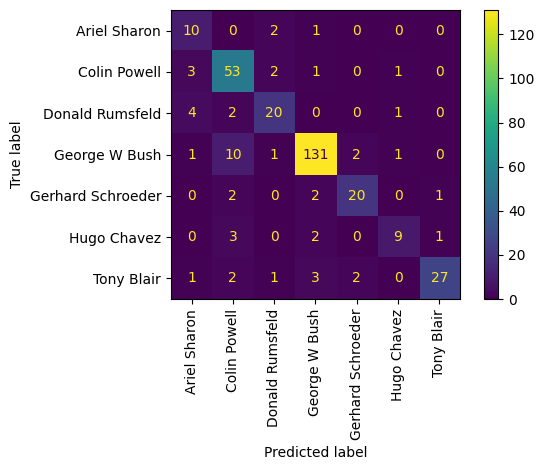

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

print(classification_report(y_test, y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

### Qualitativa
A avaliação qualitativa tem por objetivo produzir uma análise

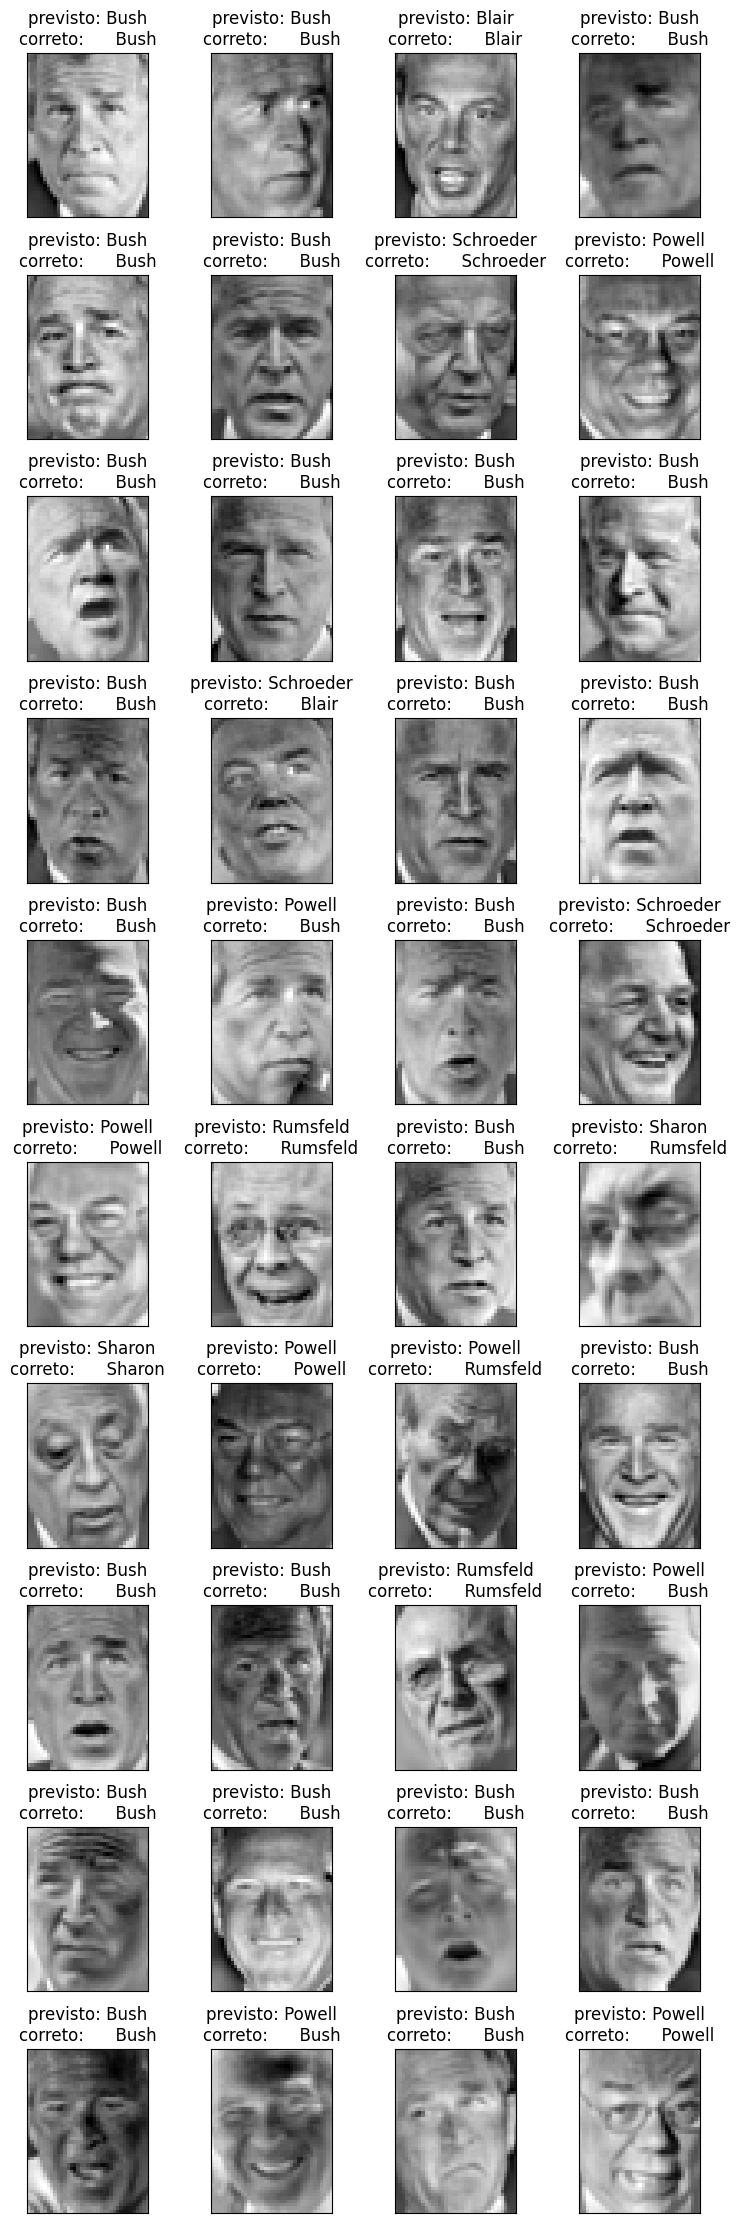

In [19]:
prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, h, w, 10, 4)

In [20]:
len(X_test)

322

In [21]:
X_test_pca.shape

(322, 150)